In [1]:
import json
from pathlib import Path

import torch
import torchaudio


In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz


--2024-03-25 13:40:16--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 172.217.24.123, 172.217.24.251, 172.217.25.27, ...
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|172.217.24.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz.1’

nsynth-test.jsonwav 100%[===================>] 333.31M  27.2MB/s    in 13s     

2024-03-25 13:40:30 (24.9 MB/s) - ‘nsynth-test.jsonwav.tar.gz.1’ saved [349501546/349501546]



In [3]:
!tar -xf nsynth-test.jsonwav.tar.gz

In [4]:
meta = json.load(open('nsynth-test/examples.json'))
len(meta)

4096

In [5]:
list(meta.keys())[0]

'bass_synthetic_068-049-025'

In [6]:
audio_dir = Path('nsynth-test/audio')
assert audio_dir.exists()

In [7]:
# fn = 'bass_electronic_018-022-100.wav'
# fn = 'vocal_synthetic_003-108-127.wav'
# fn = 'string_acoustic_057-093-100.wav'
fn = 'bass_synthetic_068-049-025.wav'
audio_fn = audio_dir / fn
assert audio_fn.exists()

In [8]:
import IPython.display as ipd

y, sr = torchaudio.load(audio_fn)
ipd.Audio(y, rate=sr)

In [9]:
fns = sorted(list(meta.keys()))
fns[:5]

['bass_electronic_018-022-100',
 'bass_electronic_018-023-025',
 'bass_electronic_018-023-075',
 'bass_electronic_018-023-127',
 'bass_electronic_018-024-025']

In [10]:
for fn in fns:
    assert (audio_dir / fn).with_suffix('.wav').exists()
    # M) Note: with_suffix라는 게 있다!

## Convert audio to spectrogram

In [11]:
y.shape

torch.Size([1, 64000])

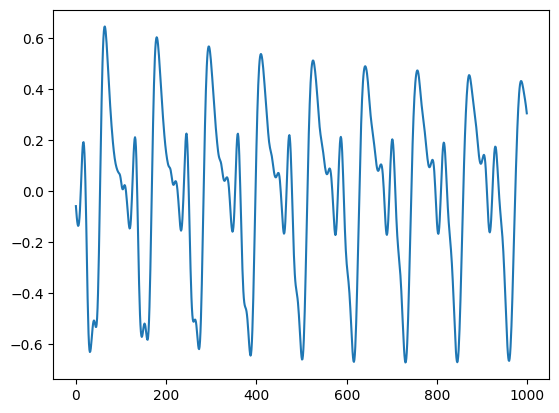

In [12]:
import matplotlib.pyplot as plt
# plt.plot(y[0]) # select specific dimension (here, channel)
plt.plot(y[0, 1000:2000])

In [13]:
# Conver audio -> spectrogram using torchaudio
spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512) # win_length는 기본적으로 n_fft와 같다.
spec = spec_converter(y)

In [14]:
spec.shape # num_channels, num frequency bin, num time bin
# note: num frequency bin = n_fft // 2 + 1

torch.Size([1, 513, 126])

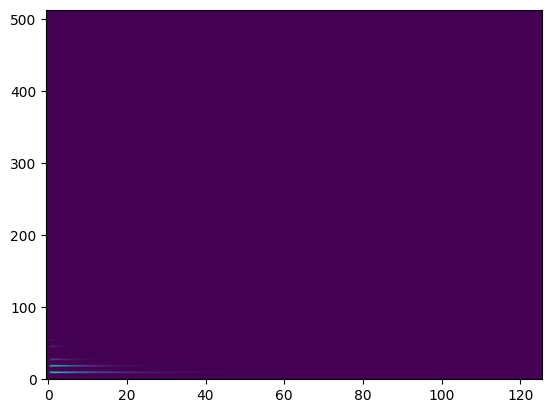

In [15]:
plt.imshow(spec[0], aspect='auto', origin='lower')
# aspect='auto': 이미지 비율 맞추기
# origin='lower': 아래에서 위로 갈수록 y값 커지게. pitch가 위로 갈수록 위에 위치하도록

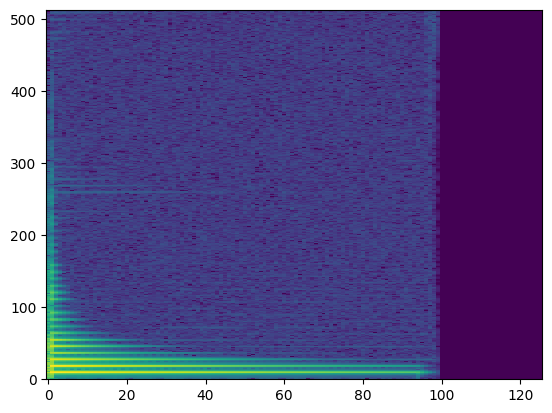

In [16]:
db_converter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_converter(spec)
plt.imshow(db_spec[0], aspect='auto', origin='lower', interpolation = 'none')

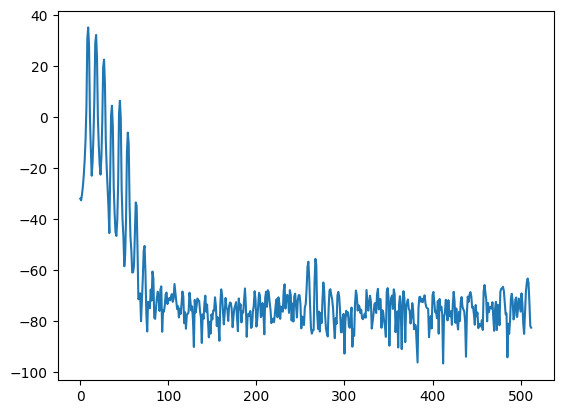

In [17]:
time_idx = 10
spectrum = db_spec[0, :, time_idx] # select 0th channel, all frequency, time_idx. note: time은 세 번째 축이다
plt.plot(spectrum)

In [18]:
# compress frequency scale to log scale
mel_scale = torchaudio.transforms.MelScale(n_mels=40, sample_rate=sr, f_min=20, f_max=4000, n_stft=513)
"""
n_mels: 몇 개의 bin으로 압축하고 싶은지
f_min, f_max: 최소, 최대 주파수
"""
mel_scale.fb # shape: [513, 40]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3337, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

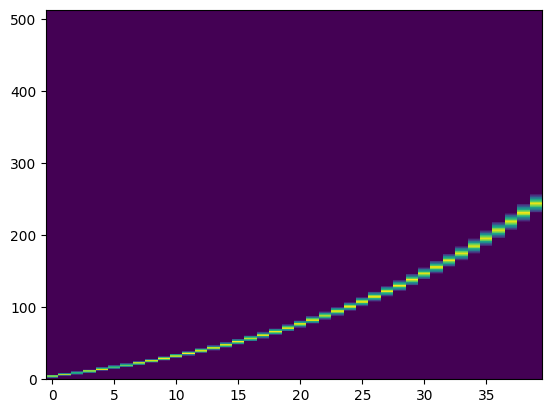

In [19]:
plt.imshow(mel_scale.fb, aspect='auto', origin='lower', interpolation='none')

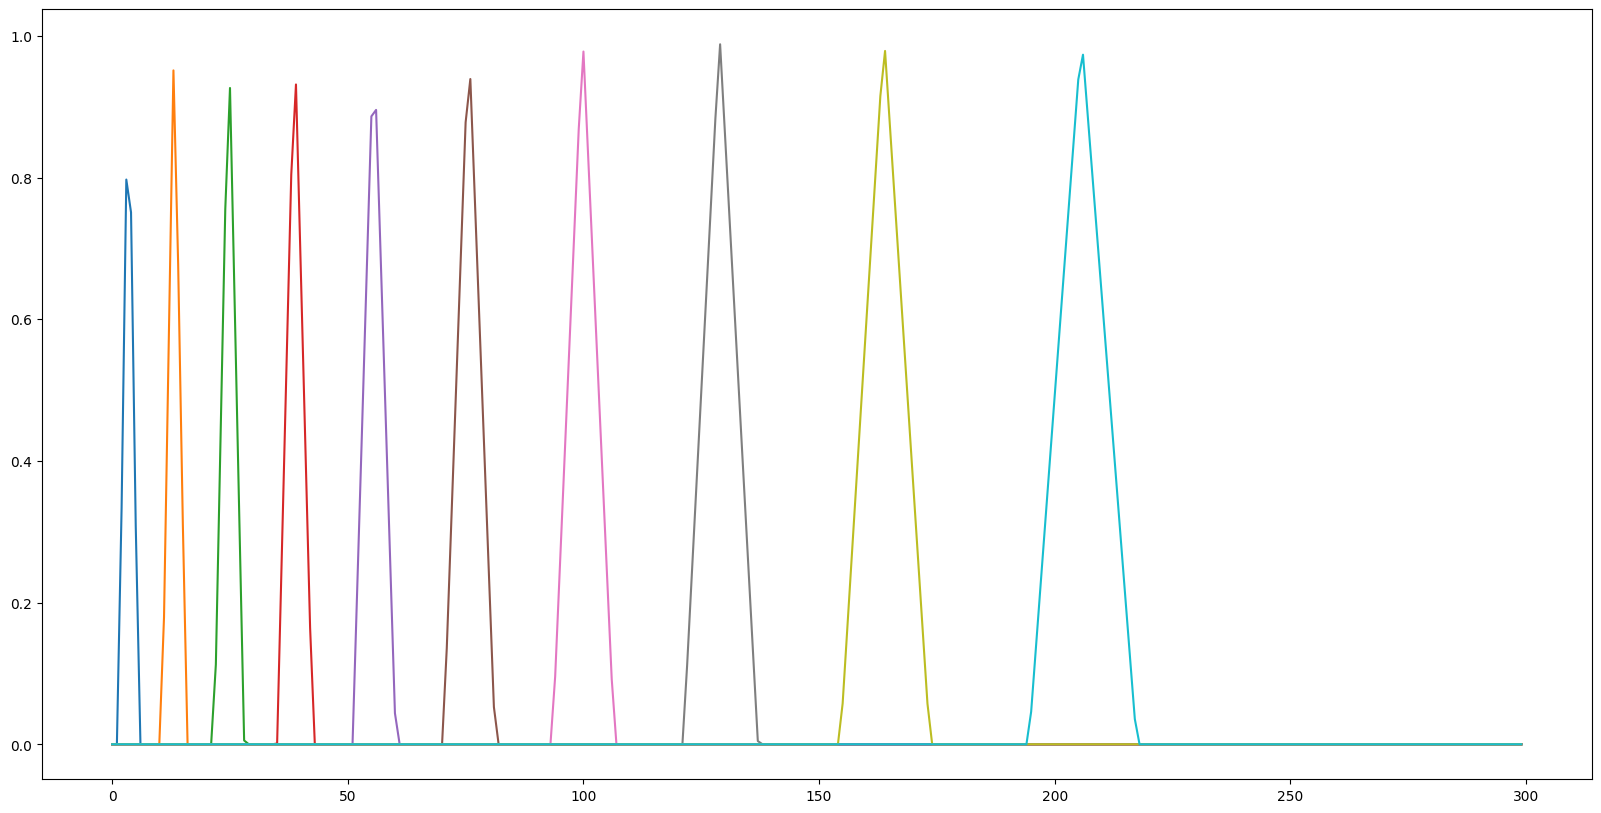

In [20]:
plt.figure(figsize=(20, 10))
for i in range(0, mel_scale.fb.shape[1], 4):
    plt.plot(mel_scale.fb[:300, i])

In [21]:
mel_spec = torch.mm(mel_scale.fb.t(), db_spec[0])
spec.shape, mel_spec.shape, mel_spec.shape

(torch.Size([1, 513, 126]), torch.Size([40, 126]), torch.Size([40, 126]))

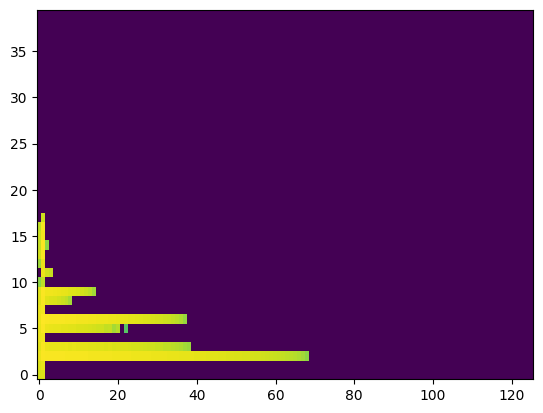

In [22]:
plt.imshow(db_converter(mel_spec), aspect='auto', origin='lower', interpolation='none')

M) 왜 이상하게 나옴!

mel spectrogram -> spectrogram으로 바꾸는 건 간단하게는 불가능하다. mel로 바꾸면서 이미 정보가 손실되었기 때문에

MelDBConverter: torch.nn.Module 상속해서 만드는 이유 -> 나중에 GPU에 한번에 올릴 수 있도록

note) shepard tone 만들고 spectrogram 그려보기

### set(pitch)가 max 119, length 106일 때
전체 class를 그냥 길이가 120인 리스트로 만들어놓는 게 나중에도 편하다. 변환하는 것을 놓칠 수도 있고, 아무튼 복잡해짐. (근데 나는 왠지 이렇게 취약한 부분을 남겨두는 게 좀 그렇긴 한데 코드 짤 때는 편할 듯) 그리고 모델을 학습하다 보면 빈 label로 향하는 데이터가 전혀 없기 때문에, 그 label에는 항상 0에 가까운 확률을 내보내야 하고, 따라서 나중에 여기에 해당하는 bias는 -inf에 가까운 값이 됨.

### Note
- sin wave와 sampling rate에 관해 설명하신 거 다시 보기
- 일정한 박자의 beat를 치다가, 그것이 어느 정도의 주파수에 들어 오면 (ex. 220hz 정도? 보다 높아지면) 그것이 음으로 인식되기 시작함

# Loss
- cross entropy: -sum(target * log(pred)) # target true label, pred는 예측한 값
- negative log likelihood: -log(pred) # softmax에서만 사용 가능 (M: 왜? 이해 덜 됨)
- TODO(minigb): 나중에 확인해보기

# layer visualization